In [50]:
import uuid
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval

# add parent directory to sys path so we could access project modules
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

# get directory for saving results of plotting graphs
diagrams = os.path.join("..", "diagrams")

In [54]:
# Perfrom Extracting and some Transforming
# and convert columns from string list to list
df = pd.read_csv("../jobs.csv", converters={
    "contracts": literal_eval,
    "employment_type": literal_eval,
    "level_of_exp": literal_eval,
    "optional_skills": lambda v: literal_eval(v) if v else np.nan,
    "os": lambda v: literal_eval(v) if v else np.nan,
    "required_skills": literal_eval,
})

df.head()

,contracts,employment_type,level_of_exp,location,optional_skills,os,required_skills,ua_support
0,[full-time],[hybrid work],[mid],Kraków,NaN,NaN,"[Python, C#, C++, Java]",True
1,[full-time],"[home office work, hybrid work]",[mid],Wrocław,"[Redis, PostgreSQL, Microsoft Power BI, BigQuery]",NaN,"[Python, Docker, Google Cloud Platform]",True
2,[full-time],[home office work],"[mid, senior]",Warszawa,NaN,NaN,"[Python, Microsoft Azure, AWS, Ansible]",False
3,[full-time],[home office work],[mid],Warszawa,"[Linux, macOS, Windows]",NaN,"[Python, SQL, PostgreSQL]",True
4,[full-time],[home office work],[senior],Kraków,"[Jenkins, Docker, Git, Marshmallow, Firebase]",NaN,"[DynamoDB, CloudFormation, Pytest, Python, AWS]",False


In [52]:
# Perfrom Transforming

# replace all empty list '[]' with nan
df.contracts = df.contracts.apply(lambda v: v if v else np.nan)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   contracts        543 non-null    object
 1   employment_type  550 non-null    object
 2   level_of_exp     550 non-null    object
 3   location         550 non-null    object
 4   optional_skills  381 non-null    object
 5   os               148 non-null    object
 6   required_skills  550 non-null    object
 7   ua_support       550 non-null    bool  
dtypes: bool(1), object(7)
memory usage: 30.7+ KB


In [56]:
# Make each values in employment_type, os, level_of_exp, contracts column.
# This approach is aligned with database normalization principles
# which aim to reduce redundancy and improve data integrity.

# where 1 indicates True and 0 False
contracts = df.contracts.explode()
contracts = pd.crosstab(contracts.index, contracts)

level_of_exp = df.level_of_exp.explode()
level_of_exp = pd.crosstab(level_of_exp.index, level_of_exp)

employment_types = df.employment_type.explode()
employment_types = pd.crosstab(employment_types.index, employment_types)

o_s = df.os.explode()
o_s = pd.crosstab(o_s.index, o_s)

# df = df.join(o_s)[o_s.columns.to_list()].fillna(0)
# df[o_s.columns.to_list()].astype(np.int8).head()

# df = df.join(employment_types)
df = df.drop(["contracts", "employment_type", "level_of_exp", "os"], axis=1)
df.head()

,location,optional_skills,required_skills,ua_support
0,Kraków,NaN,"[Python, C#, C++, Java]",True
1,Wrocław,"[Redis, PostgreSQL, Microsoft Power BI, BigQuery]","[Python, Docker, Google Cloud Platform]",True
2,Warszawa,NaN,"[Python, Microsoft Azure, AWS, Ansible]",False
3,Warszawa,"[Linux, macOS, Windows]","[Python, SQL, PostgreSQL]",True
4,Kraków,"[Jenkins, Docker, Git, Marshmallow, Firebase]","[DynamoDB, CloudFormation, Pytest, Python, AWS]",False


In [57]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Define a function to remove duplicates and update counts
def removing_duplicates(tool_counts) -> dict:
    """
    Removing duplicates, exp 'AI', 'AI services' - is same,
    'AI' should stay, and 'AI services' count value should be
    added to 'AI' count
    """
    unq_words = {}
    duplicates = set()

    # Sort tool_counts by length of keys (tool names)
    tool_counts_sorted = tool_counts.sort_index(key=lambda v: v.str.len())

    for tool, count in tool_counts_sorted.items():
        if tool not in duplicates:
            matches = process.extractBests(
                tool, 
                tool_counts_sorted.index, 
                scorer=lambda str1, str2: fuzz.ratio(str1.lower(), str2.lower()),
                score_cutoff=70
            )
            
            # Filter out matches that are similar to the current tool
            filtered_matches = {match for match, score in matches if match != tool and (
                match.lower().startswith(tool.lower()) or score >= 85
            )}
            
            # Add count of similar tools to the current tool
            unq_words[tool] = count + sum(tool_counts[match] for match in filtered_matches)
            duplicates |= filtered_matches

    return unq_words

In [86]:
# Concatenate all required and optional skills into one Series
required_skills = pd.Series(df.required_skills.sum())
optional_skills = pd.Series(df.optional_skills.dropna().sum())

# Count the occurrences of each skill
required_skills_counts = required_skills.value_counts()
optional_skills_counts = optional_skills.value_counts()

Python     123
Windows     74
Linux       50
AWS         36
Java        32
Name: count, dtype: int64

In [101]:
# Remove duplicates, because we have scraped data not only 
# from setted up labels on website but also we have processed text requirements
# and update counts for optional and required skills
required_skills_dict = removing_duplicates(required_skills_counts)
optional_skills_dict = removing_duplicates(optional_skills_counts)

# Create DataFrames from dictionary
required_skills_df = pd.DataFrame(
    {
        "skills": list(required_skills_dict.keys()),
        "count": list(required_skills_dict.values())
    }
)
optional_skills_df = pd.DataFrame(
    {
        "skills": list(optional_skills_dict.keys()),
        "count": list(optional_skills_dict.values())
    }
)

# Sort DataFrame by count in descending order
required_skills_df = required_skills_df.sort_values(by="count", ascending=False)
optional_skills_df = optional_skills_df.sort_values(by="count", ascending=False)

# save required_skills_counts and optional_skills_counts
required_skills_df.to_csv("../required_skills.csv", index=False)
optional_skills_df.to_csv("../optional_skills.csv", index=False)

optional_skills_df.head(), required_skills_df.head()

(      skills  count
 126   Python    124
 183  Windows     74
 101    Linux     50
 22       AWS     36
 48      Java     32,
      skills  count
 155  Python    430
 31      SQL    186
 1         C    123
 32      AWS     91
 28      GIT     85)

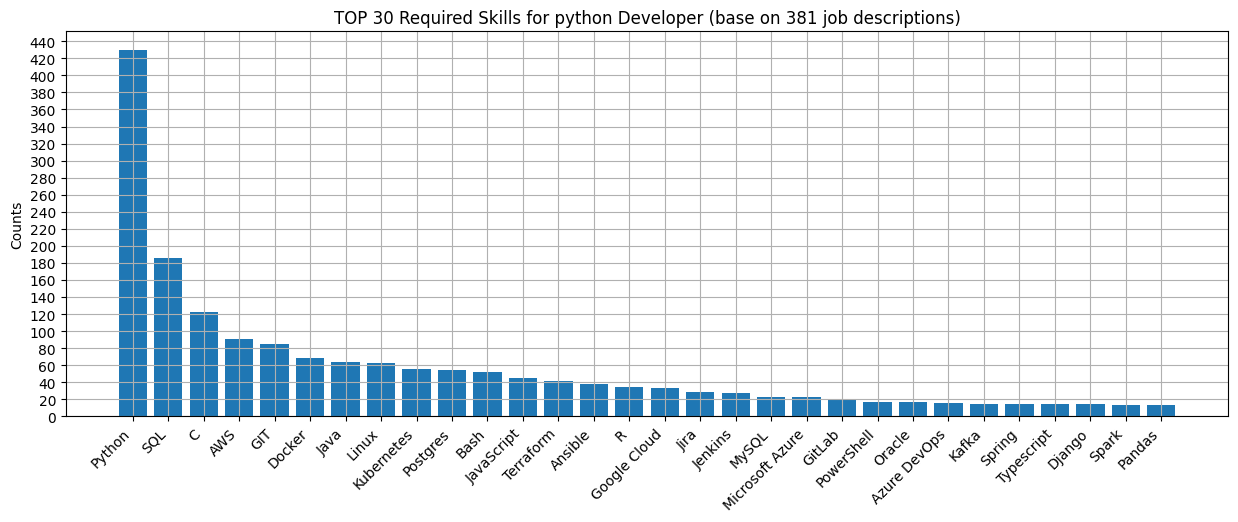

In [93]:
from config import POSITION

# get top 30 required skills
top_skills = required_skills_df.iloc[:30, :]

plt.figure(figsize=(15, 5))
plt.bar(top_skills.skills, top_skills["count"])

plt.title(f"TOP {top_skills.shape[0]} Required Skills for {POSITION} Developer (base on {df.shape[0]} job descriptions)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Counts")
plt.yticks(range(0, top_skills["count"].max() + 20, 20))
plt.grid(True)

# save diagram
# required_skills_diagram = os.path.join(diagrams, "required_skills")
# plt.savefig(os.path.join(required_skills_diagram, f"required_skills_{uuid.uuid4()}.jpg"))

plt.show()

In [103]:
from config import POSITION

# get top 30 optional skills
top_skills = optional_skills_df.iloc[:30, :]

plt.figure(figsize=(15, 5))
plt.bar(top_skills.skills, top_skills["count"])

plt.title(f"TOP {top_skills.shape[0]} Optional Skills for {POSITION} Developer (base on {len(df.optional_skills} job descriptions)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Counts")
plt.yticks(range(0, top_skills["count"].max() + 20, 20))
plt.grid(True)

# save diagram
# optional_skills_diagram = os.path.join(diagrams, "optional_skills")
# plt.savefig(os.path.join(optional_skills_diagram, f"optional_skills_{uuid.uuid4()}.jpg"))

plt.show()

SyntaxError: f-string: closing parenthesis '}' does not match opening parenthesis '(' (2164742847.py, line 9)

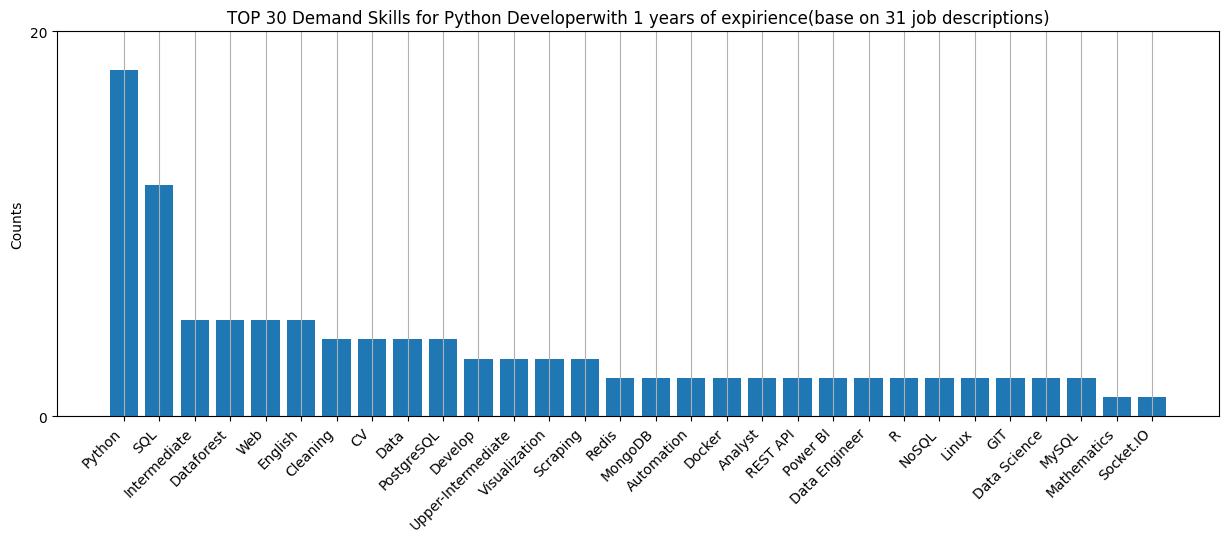

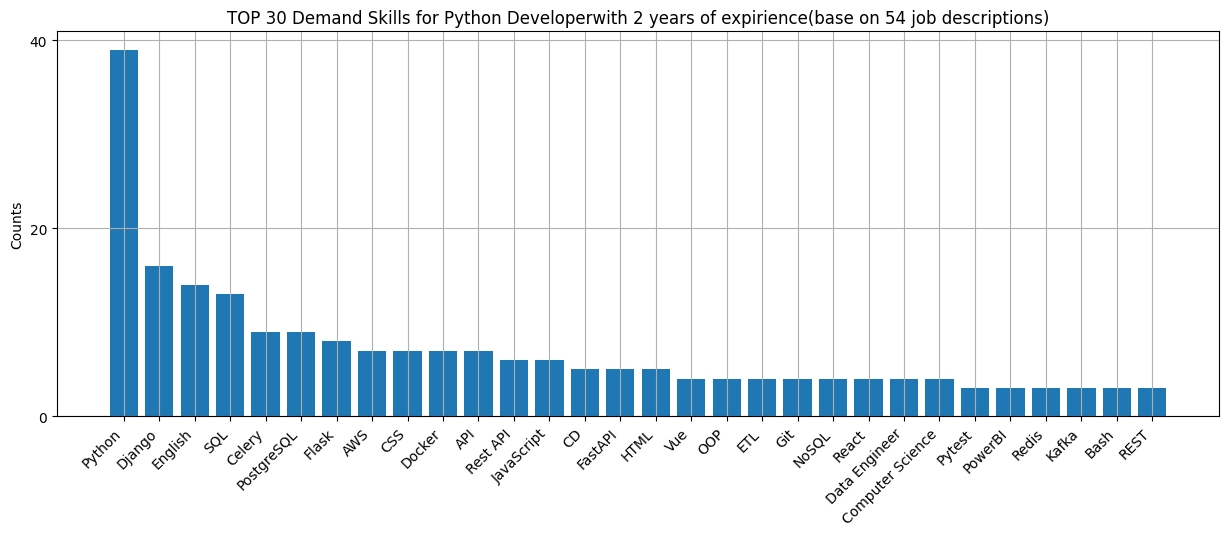

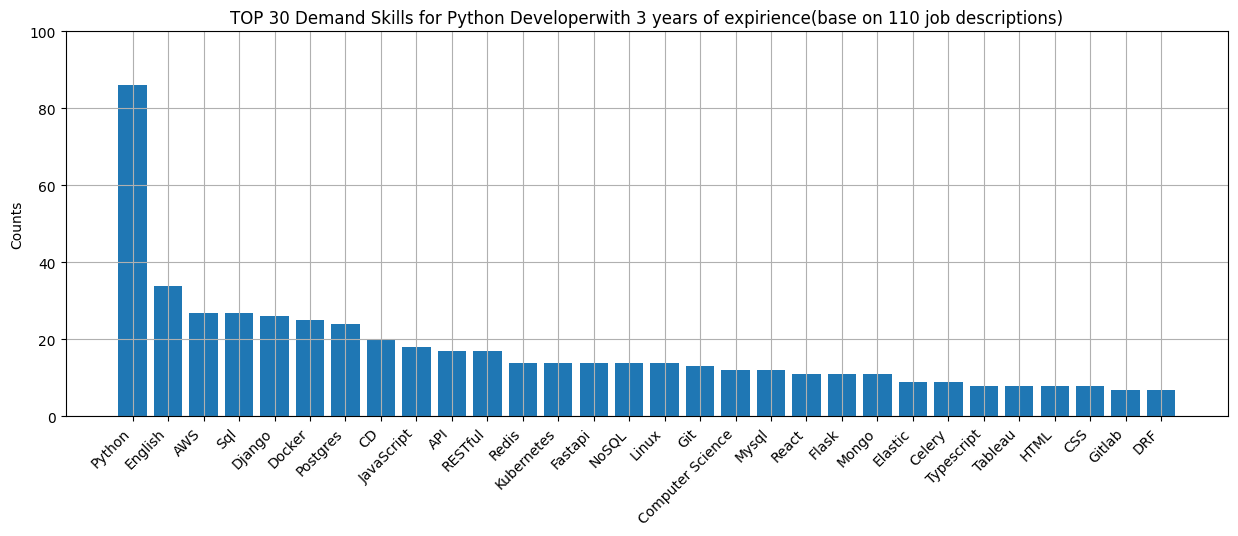

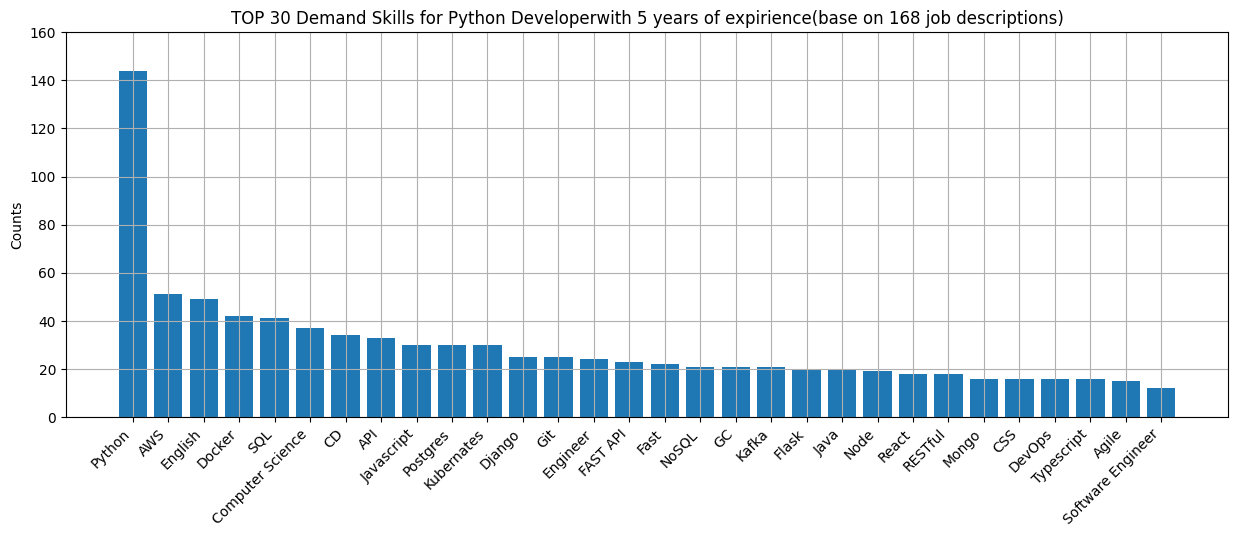

In [10]:
# group by year of expirience
grouped = df.groupby("year_of_exp")


# create a bar plot for each year of exprience
# and we are not using subplots() because we want to save each plot seperatly
for i, (year, data) in enumerate(grouped):
   
    all_skills = pd.Series(data['tools'].sum())
    # Count the occurrences of each tool
    skill_counts = all_skills.value_counts()
    
    skills = removing_duplicates(skill_counts)
    # Create DataFrame from dictionary
    skills = pd.DataFrame({'tools': list(skills.keys()), 'count': list(skills.values())})
    # Sort DataFrame by count in descending order
    skills = skills.sort_values(by='count', ascending=False)
    
    top_skills = skills.iloc[:30, :]
    
    plt.figure(figsize=(15, 5))
    plt.bar(top_skills.tools, top_skills["count"])
    
    plt.title((
        f"TOP {len(top_skills)} Demand Skills for {POSITION} Developer"
        f"with {year} years of expirience(base on {len(data)} job descriptions)"
    ))
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Counts")
    plt.yticks(range(0, top_skills["count"].max() + 20, 20))
    plt.grid(True)
   
    # save diagram
    by_year = os.path.join(diagrams, f"{year}_year_of_exp")
    os.makedirs(by_year, exist_ok=True)
    plt.savefig(os.path.join(by_year, f"skills_{uuid.uuid4()}.jpg"))

    plt.show()
    plt.close()

In [ ]:
# See djinni Job Locations
countries = pd.Series(df.country.sum())
countries = countries.value_counts()

# get top 20 countries job vacancies offering
top_countries = countries[:30]

plt.figure(figsize=(15, 5))
plt.bar(top_countries.index, top_countries)

plt.title(f"TOP {len(top_countries)} countries vacancies offer to work for {POSITION} Developer (base on {df.shape[0]} job descriptions)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Counts")
plt.yticks(range(0, countries.max() + 20, 20))
plt.grid(True)
plt.show()

# See djinni employment type
empl_count = df[["hybrid", "office", "remote"]].sum()

plt.figure(figsize=(10, 5))
plt.bar(empl_count.index, empl_count)

plt.title(f"Employment type for {POSITION} Developer (base on {df.shape[0]} job descriptions)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Counts")
plt.show()

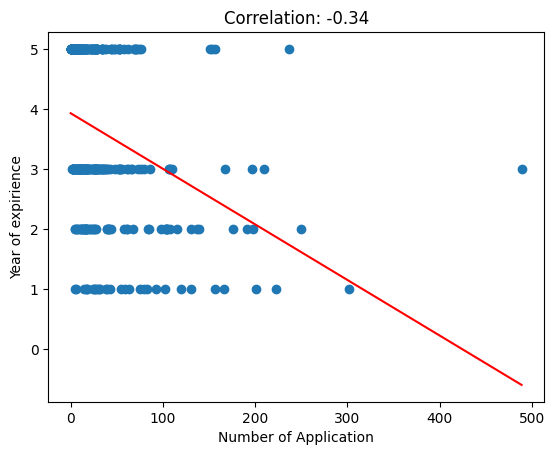

In [15]:
# See the correlation between year of expirience and number of applications
# either year of expirience increases number of application or not.

x, y = df["num_applications"], df["year_of_exp"]
plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
plt.title(f"Correlation: {round(x.corr(y), 2)}")
plt.ylabel("Year of expirience")
plt.xlabel("Number of Application")
plt.show()

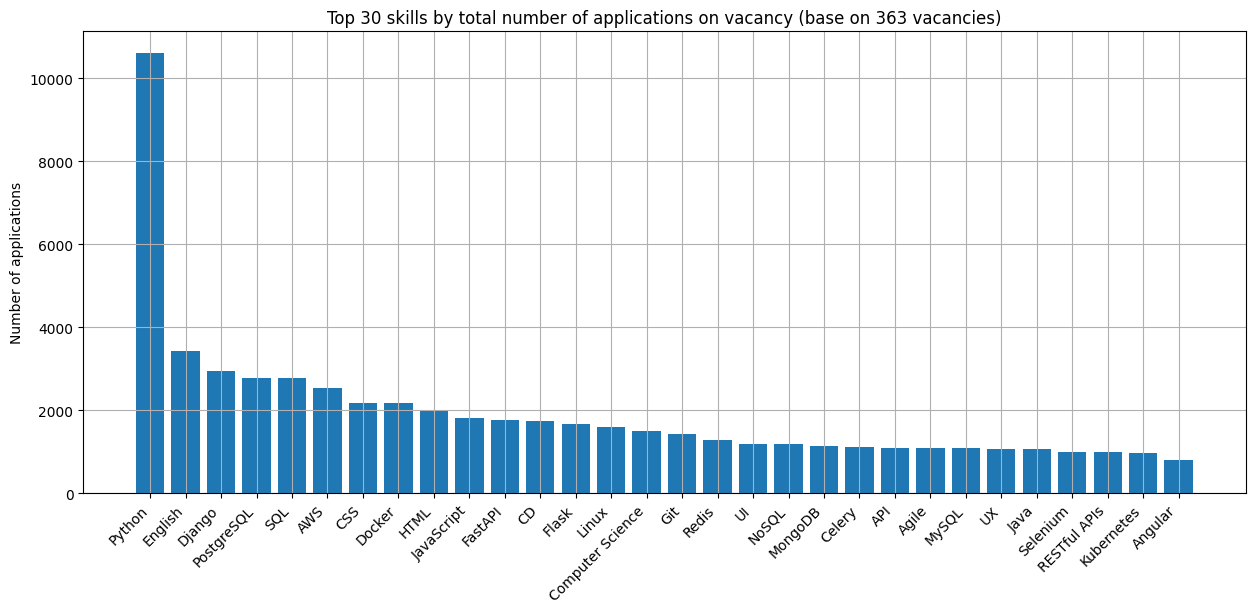

In [36]:
# Show top skills by each skill total number of applications on vacancy
skills = df.explode("tools")

skill_application = skills.groupby("tools")["num_applications"].sum().reset_index()
skills = skill_application.sort_values(by="num_applications", ascending=False)
top_skills = skills.iloc[:30, :]

plt.figure(figsize=(15, 6))
plt.bar(top_skills["tools"], top_skills["num_applications"])

plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of applications")
plt.title(f"Top {top_skills.shape[0]} skills by total number of applications on vacancy (base on {df.shape[0]} vacancies)")
plt.grid(True)

by_applications = os.path.join(diagrams, "by_applications")
plt.savefig(os.path.join(by_applications, f"skills_{uuid.uuid4()}.jpg")

plt.show()

In [11]:
# loading
df.to_csv("../jobs.csv")